# Model Evaluation in PyMC-Marketing

This notebook demonstrates how to evaluate Marketing Mix Models using PyMC-Marketing's evaluation metrics and functions. We'll cover:

1. Standard evaluation metrics (RMSE, MAE, MAPE)
2. Normalized metrics (NRMSE, NMAE)
3. Calculating and visualizing metric distributions and summaries of those distributions
4. Creating evaluation plots (prior vs posterior plots)

First, let's import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    root_mean_squared_error,
)

from pymc_marketing.mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.mmm.evaluation import (
    calculate_metric_distributions,
    compute_summary_metrics,
    summarize_metric_distributions,
)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [12]:
seed: int = sum(map(ord, "mmm-evaluation"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
hdi_prob: float = 0.89  # change this to whatever HDI you want

## Setting up a Demo Model

Let's first create a simple MMM model using the example dataset:

In [3]:
# Load example data
data_url = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv"
data = pd.read_csv(data_url, parse_dates=["date_week"])

X = data.drop("y", axis=1)
y = data["y"]

# Create and fit the model
mmm = MMM(
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    yearly_seasonality=2,
)

fit_kwargs = {
    "tune": 1_500,
    "chains": 4,
    "draws": 2_000,
    "nuts_sampler": "numpyro",
    "target_accept": 0.92,
    "random_seed": rng,
}
_ = mmm.fit(X, y, **fit_kwargs)

# Generate posterior predictive samples
posterior_preds = mmm.sample_posterior_predictive(X, random_seed=rng)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Sampling: [y]


Output()

## Understanding the Evaluation Metrics

PyMC-Marketing provides several metrics for evaluating your models:

1. Standard metrics from scikit-learn:
   - RMSE (Root Mean Squared Error)
   - MAE (Mean Absolute Error)
   - MAPE (Mean Absolute Percentage Error)

2. Bayesian R-Squared (from `arviz.az.r2_score`)

3. Normalized metrics:
   - NRMSE (Normalized Root Mean Squared Error), such as is used by Robyn
   - NMAE (Normalized Mean Absolute Error)

Let's calculate these metrics for our model:

In [13]:
# Calculate metrics for all posterior samples
results = compute_summary_metrics(
    y_true=mmm.y,
    y_pred=posterior_preds.y,
    metrics_to_calculate=["r_squared", "rmse", "nrmse", "mae", "nmae", "mape"],
    hdi_prob=hdi_prob,
)

# Print results in a formatted way
for metric, stats in results.items():
    print(f"\n{metric.upper()}:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.4f}")


R_SQUARED:
  mean: 0.9055
  median: 0.9061
  std: 0.0100
  min: 0.8612
  max: 0.9354
  89%_hdi_lower: 0.8899
  89%_hdi_upper: 0.9217

RMSE:
  mean: 351.6700
  median: 350.9463
  std: 19.9473
  min: 283.8833
  max: 442.2503
  89%_hdi_lower: 320.4031
  89%_hdi_upper: 383.9887

NRMSE:
  mean: 0.0687
  median: 0.0686
  std: 0.0039
  min: 0.0555
  max: 0.0864
  89%_hdi_lower: 0.0626
  89%_hdi_upper: 0.0750

MAE:
  mean: 281.5586
  median: 280.9010
  std: 16.7971
  min: 217.7636
  max: 348.5336
  89%_hdi_lower: 253.8389
  89%_hdi_upper: 307.5370

NMAE:
  mean: 0.0550
  median: 0.0549
  std: 0.0033
  min: 0.0425
  max: 0.0681
  89%_hdi_lower: 0.0496
  89%_hdi_upper: 0.0601

MAPE:
  mean: 0.0557
  median: 0.0555
  std: 0.0034
  min: 0.0432
  max: 0.0696
  89%_hdi_lower: 0.0502
  89%_hdi_upper: 0.0610


`compute_summary_metrics` actually combines the steps of two other functions:

1. `calculate_metric_distributions`
2. `summarize_metric_distributions`

The metric distributions (unsummarised) can sometimes be useful on their own, e.g. if you'd like to visualise the distribution of a metric.

In [14]:
# Calculate distributions for multiple metrics
metric_distributions = calculate_metric_distributions(
    y_true=mmm.y,
    y_pred=posterior_preds.y,
    metrics_to_calculate=["rmse", "mae", "r_squared"],
)

# Summarize the distributions
summaries = summarize_metric_distributions(metric_distributions, hdi_prob=0.89)

# Create a nice display of the summaries
for metric, summary in summaries.items():
    print(f"\n{metric.upper()} Summary:")
    print(f"  Mean: {summary['mean']:.4f}")
    print(f"  Median: {summary['median']:.4f}")
    print(f"  Standard Deviation: {summary['std']:.4f}")
    print(
        f"  89% HDI: [{summary['89%_hdi_lower']:.4f}, {summary['89%_hdi_upper']:.4f}]"
    )


RMSE Summary:
  Mean: 351.6700
  Median: 350.9463
  Standard Deviation: 19.9473
  89% HDI: [320.4031, 383.9887]

MAE Summary:
  Mean: 281.5586
  Median: 280.9010
  Standard Deviation: 16.7971
  89% HDI: [253.8389, 307.5370]

R_SQUARED Summary:
  Mean: 0.9055
  Median: 0.9061
  Standard Deviation: 0.0100
  89% HDI: [0.8899, 0.9217]


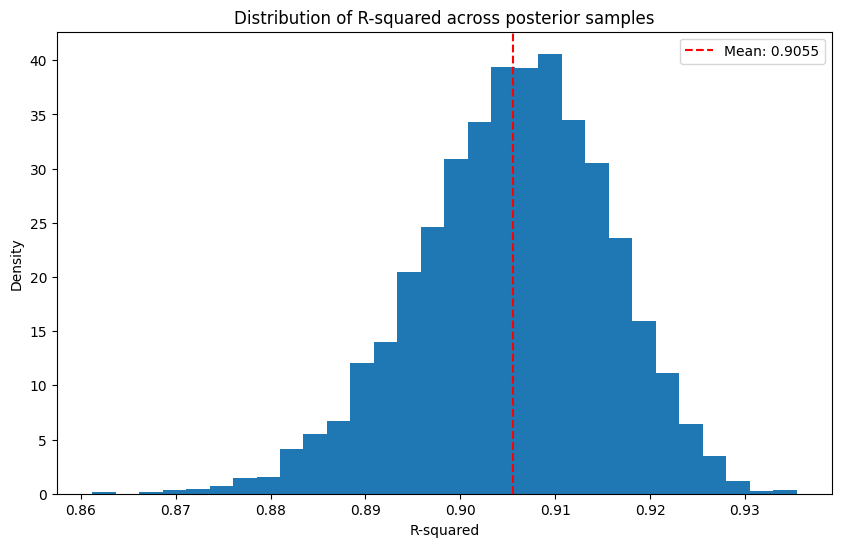

In [21]:
# Visualise the distribution of R-squared
plt.figure(figsize=(10, 6))
plt.hist(metric_distributions["r_squared"], bins=30, density=True)
plt.axvline(
    summaries["r_squared"]["mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {metric_distributions['r_squared'].mean():.4f}",
)
plt.title("Distribution of R-squared across posterior samples")
plt.xlabel("R-squared")
plt.ylabel("Density")
plt.legend()
plt.show()

## Understanding Metric Distributions in Bayesian Models

In Bayesian modeling, we tend to work with distributions rather than point estimates. This is particularly important for model evaluation metrics because:

1. **E[f(x)] is not guaranteed to be f(E[x])**: This means calculating metrics on mean predictions can give different (and potentially misleading) results compared to calculating the distribution of metrics across posterior samples.

2. **Uncertainty Quantification**: Having distributions of metrics allows us to understand the uncertainty in our model's performance.

Let's demonstrate this with an example:

RMSE calculated on mean predictions: 237.9878
Mean of RMSE distribution: 351.6700


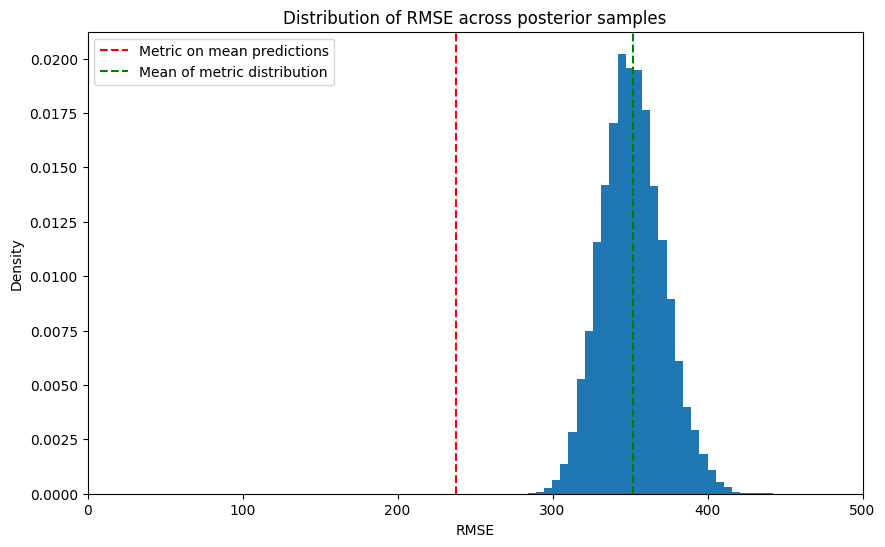

In [23]:
# Wrong way: Calculate metrics using mean predictions
mean_predictions = posterior_preds.y.mean(axis=1)
naive_rmse = root_mean_squared_error(mmm.y, mean_predictions)

# Correct way: Calculate distribution of metrics
metric_distributions = calculate_metric_distributions(
    y_true=mmm.y, y_pred=posterior_preds.y, metrics_to_calculate=["rmse"]
)

proper_rmse_mean = metric_distributions["rmse"].mean()

print(f"RMSE calculated on mean predictions: {naive_rmse:.4f}")
print(f"Mean of RMSE distribution: {proper_rmse_mean:.4f}")

# Visualize the RMSE distribution
plt.figure(figsize=(10, 6))
plt.hist(metric_distributions["rmse"], bins=30, density=True)
plt.axvline(naive_rmse, color="red", linestyle="--", label="Metric on mean predictions")
plt.axvline(
    proper_rmse_mean, color="green", linestyle="--", label="Mean of metric distribution"
)
plt.title("Distribution of RMSE across posterior samples")
plt.xlim(0, 500)
plt.xlabel("RMSE")
plt.ylabel("Density")
plt.legend()
plt.show()

## Comparing Prior vs Posterior Distributions

We can also visualize how our prior beliefs compare to the posterior distributions using the `plot_prior_vs_posterior` method:

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept, saturation_beta, saturation_lam, y, y_sigma]


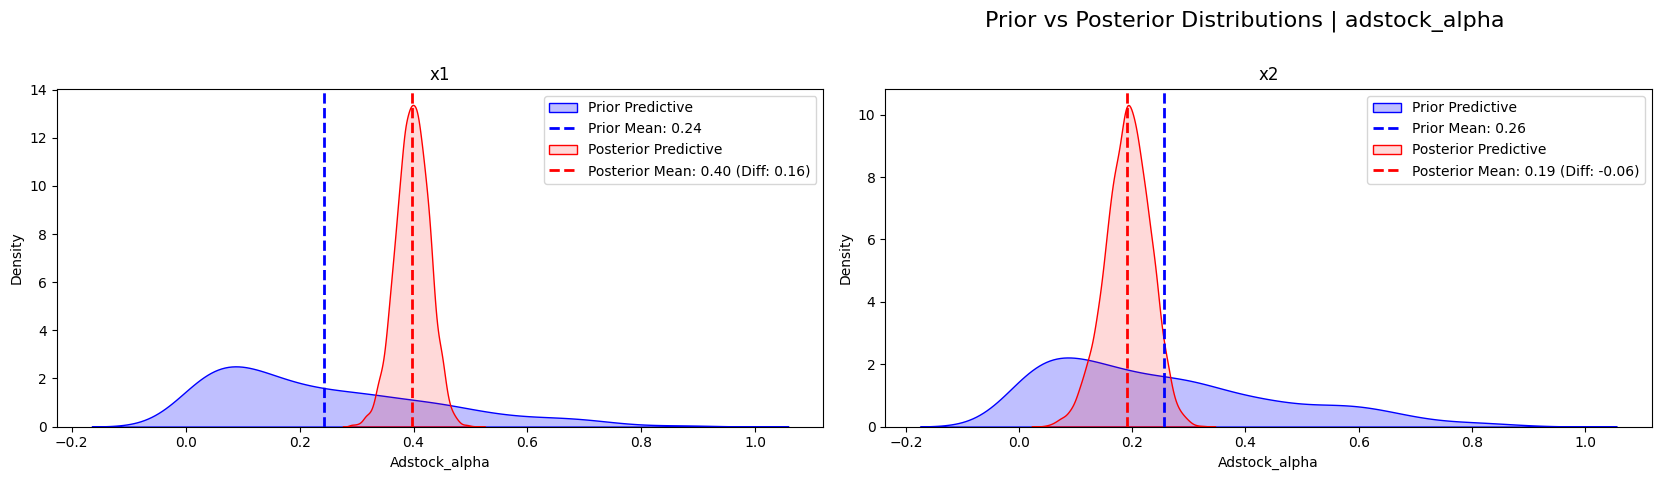

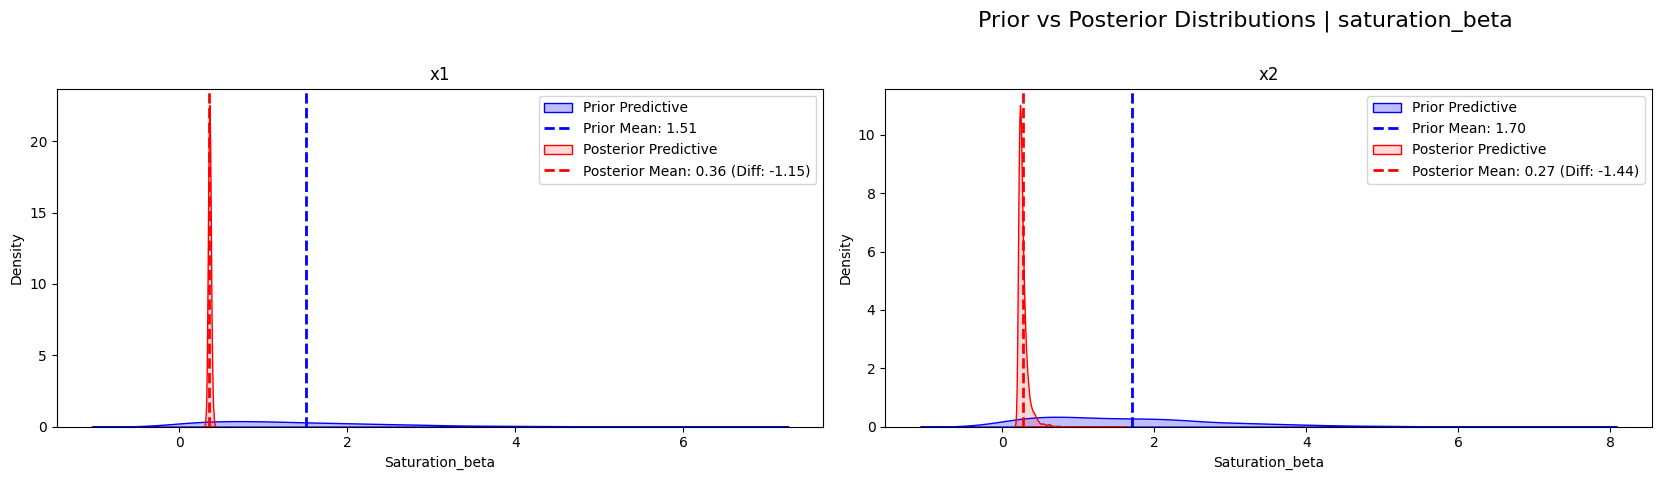

In [7]:
# First, sample from the prior
prior_preds = mmm.sample_prior_predictive(X, random_seed=rng)

# Plot prior vs posterior for adstock parameter
fig = mmm.plot_prior_vs_posterior(
    var_name="adstock_alpha",
    alphabetical_sort=True,  # Sort channels alphabetically
)
plt.show()

# Plot prior vs posterior for saturation parameter
fig = mmm.plot_prior_vs_posterior(
    var_name="saturation_beta",
    alphabetical_sort=False,  # Sort by difference between prior and posterior means
)
plt.show()

These visualizations help us understand:

1. How much we learned from the data (difference between prior and posterior)
2. The uncertainty in our parameter estimates (width of the distributions)
3. Whether our priors were reasonable (by comparing prior and posterior ranges)

The `plot_prior_vs_posterior` method allows us to sort channels either alphabetically or by the magnitude of change from prior to posterior, helping identify which channels had the strongest updates from the data.

## Conclusion

In this notebook, we've demonstrated how to:

1. Calculate various evaluation metrics for your MMM including normalized versions (NRMSE, NMAE), as both summaries and distributions
2. Visualize metric distributions for a chosen evaluation metric
3. Compare prior vs posterior distributions for different metrics

These tools help us understand model performance and uncertainty in our predictions, which is crucial for making informed marketing decisions.